# Compare ex2d_patch with specter

This was run on Stephen's laptop with both `specter/py` and `gpu_specter/py` in the `$PYTHONPATH`
before starting jupyter.  It could be adapted to NERSC using a DESI kernet (see Computing/JupyterAtNERSC on the DESI wiki)
plus getting a clone of gpu_specter into `sys.path`.

In [1]:
%pylab inline
import pkg_resources
import numpy as np
import specter.psf
from specter.extract import ex2d_patch as specter_ex2d_patch
from gpu_specter.extract.cpu import get_spots, projection_matrix, ex2d_patch
import gpu_specter.io

Populating the interactive namespace from numpy and matplotlib


## Load PSFs

In [2]:
psffile = pkg_resources.resource_filename('gpu_specter', 'test/data/psf-r0-00051060.fits')
psf0 = specter.psf.load_psf(psffile)
psf1 = gpu_specter.io.read_psf(psffile)

## Create some fake input spectra

In [3]:
wavelengths = np.arange(6000, 6050, 1)
nwave = len(wavelengths)
nspec = 5
phot = np.zeros((nspec, nwave))
phot[0] = 100
phot[1] = 5*np.arange(nwave)
phot[2] = 50
phot[4] = 100*(1+np.sin(np.arange(nwave)/10.))
phot[0,10] += 500
phot[1,15] += 200
phot[2,20] += 300
phot[3,25] += 1000
phot[4,30] += 600

## Project those onto images and compare

In [4]:
spots, corners = get_spots(0, nspec, wavelengths, psf1)
A4, xyrange = projection_matrix(0, nspec, 0, nwave, spots, corners)
xmin, xmax, ymin, ymax = xyrange
A2 = A4.reshape(A4.shape[0]*A4.shape[1], A4.shape[2]*A4.shape[3])
img1 = A2.dot(phot.ravel()).reshape(ymax-ymin, xmax-xmin)
img0 = psf0.project(wavelengths, phot, xyrange=xyrange)

Images match: True


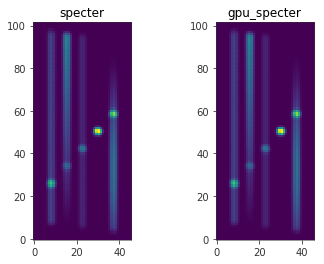

In [5]:
subplot(121); imshow(img0); title('specter')
subplot(122); imshow(img1); title('gpu_specter')
print('Images match:', np.allclose(img0, img1))

## Add noise to the image

In [6]:
readnoise = 3.0
noisyimg = np.random.poisson(img0) + np.random.normal(loc=0.0, scale=readnoise, size=img0.shape)
imgivar = 1.0/(img0 + readnoise**2)   #- for test, cheat by using noiseless img0 instead of noisyimg to estimate variance

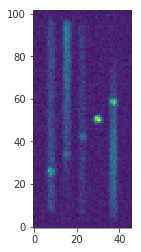

In [8]:
imshow(noisyimg)

## Extract and compare results

In [11]:
%time flux1, varflux1, R1 = ex2d_patch(noisyimg, imgivar, A4)

CPU times: user 30.4 ms, sys: 6.36 ms, total: 36.7 ms
Wall time: 40.5 ms


In [12]:
%time flux0, ivar0, R0 = specter_ex2d_patch(noisyimg, imgivar, psf0, 0, nspec, wavelengths, xyrange=xyrange)

CPU times: user 46.7 ms, sys: 3.38 ms, total: 50.1 ms
Wall time: 49.5 ms


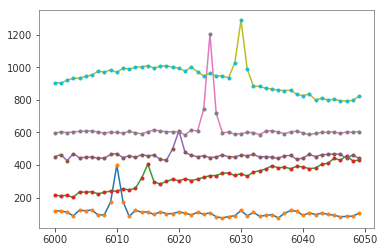

In [13]:
for i in range(nspec):
    plot(wavelengths, flux0[i] + 200*i)
    plot(wavelengths, flux1[i] + 200*i, '.')

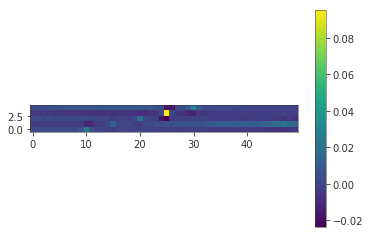

In [14]:
imshow(flux0 - flux1); colorbar()

## Comments

They mostly agree, but not quite, with one big outlier.  Known differences in methods:
  * gpu_specter uses simpler regularization to handle extracting spectra that might have completely masked pixels.
    specter regularization is more subtle, but has gotten a bit out of hand with special cases.
  * specter includes some discarding of tiny eigenvalues in `eigen_compose` used when calculating the Covariance matrix.